In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Ejercicio 1 Puesta a tierra en la Búsqueda de Google

In [1]:
%pip install -q -U 'google-generativeai>=0.8.3'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
import google.generativeai as genai
from IPython.display import Markdown, HTML, display

In [11]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

## Explorando modelos

In [12]:
for model in genai.list_models():
    if "002" in model.name:
        print(model.name)

models/gemini-1.5-pro-002
models/gemini-1.5-flash-002
models/imagen-3.0-generate-002


## Base de busqueda

In [13]:
# Ask for information without search grounding.
model = genai.GenerativeModel("gemini-1.5-flash-002")

response = model.generate_content("When and where is Taylor Swift's next concert?")

Markdown(response.text)

I do not have access to real-time information, including live concert schedules.  To find out when and where Taylor Swift's next concert is, you should check these resources:

* **Taylor Swift's Official Website:** This is the best place to get the most up-to-date and accurate information.
* **Ticketmaster:**  Check Ticketmaster for concert dates and ticket availability in your area.
* **Other Ticket Retailers:** Sites like Vivid Seats, StubHub, etc., might also list her shows.
* **Social Media:** Follow Taylor Swift's official social media accounts for announcements.


Keep in mind that concert schedules change, so checking frequently is recommended.


In [ ]:
# And now re-run the same query with search grounding enabled.
model = genai.GenerativeModel(
    "gemini-1.5-flash-002",
    tools="google_search_retrieval")

response = model.generate_content("When and where is Taylor Swift's next concert?")
rc = response.candidates[0]

Markdown(rc.content.parts[0].text)

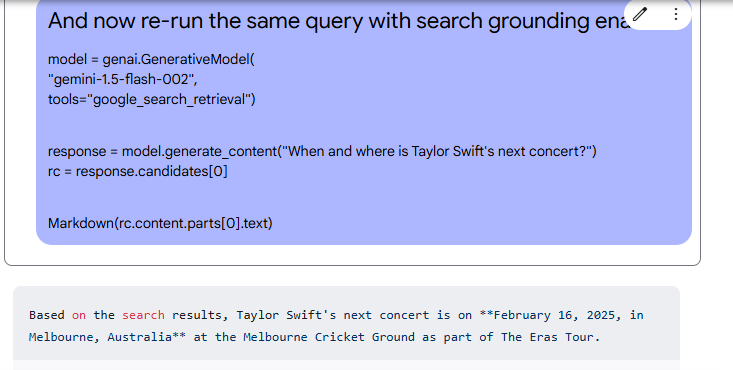

In [ ]:
chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(chunk)

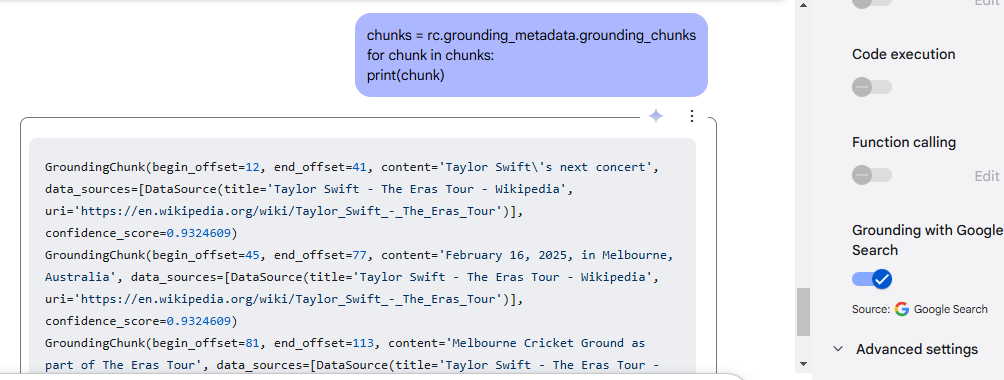

In [ ]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

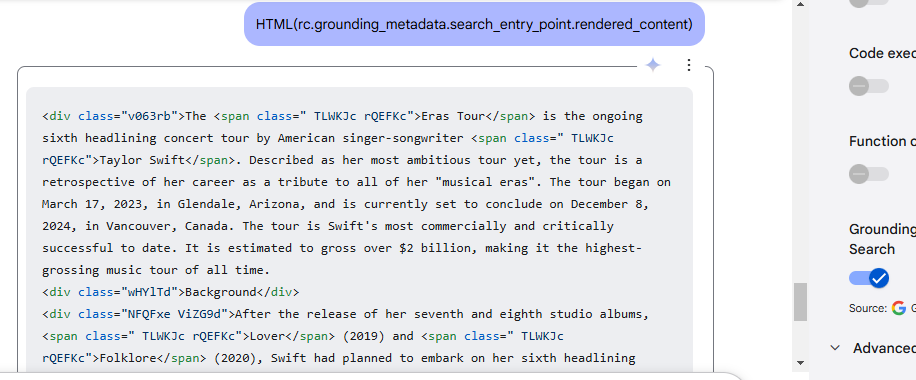

In [ ]:
supports = rc.grounding_metadata.grounding_supports
for support in supports:
    print(support)

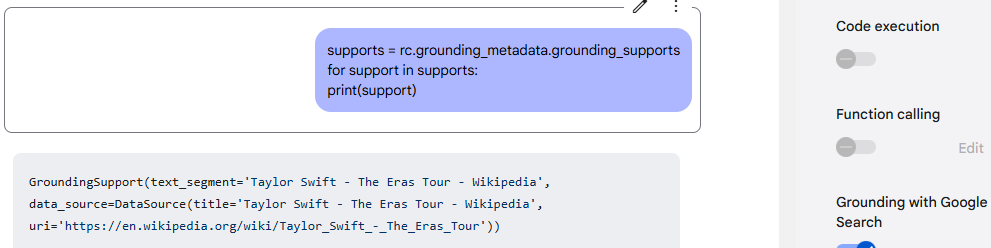

In [ ]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        response.text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"* {i}: [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

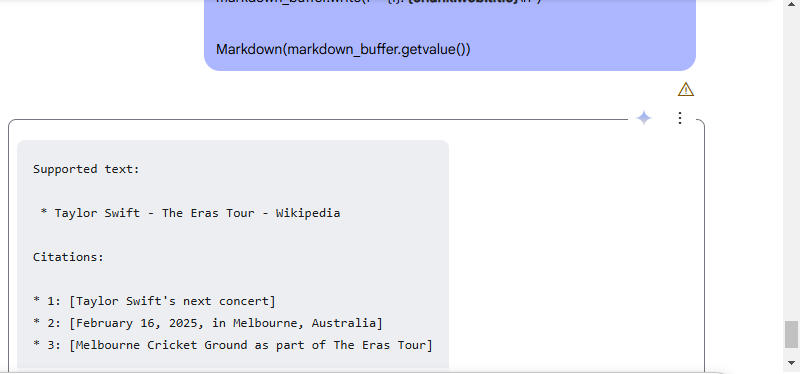

In [ ]:
nosearch_model = genai.GenerativeModel("gemini-1.5-flash-002")
chat = nosearch_model.start_chat()

# No search grounding.
r = chat.send_message("Hello friendly chatbot!")

# Enable search for just this turn.
r = chat.send_message(
    "Who took home the 2023 cricket world cup?", tools="google_search_retrieval"
)

Markdown(r.text)

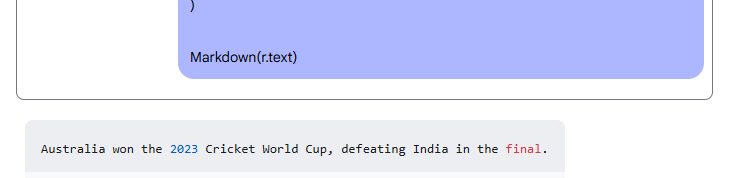

In [ ]:
HTML(r.candidates[0].grounding_metadata.search_entry_point.rendered_content)

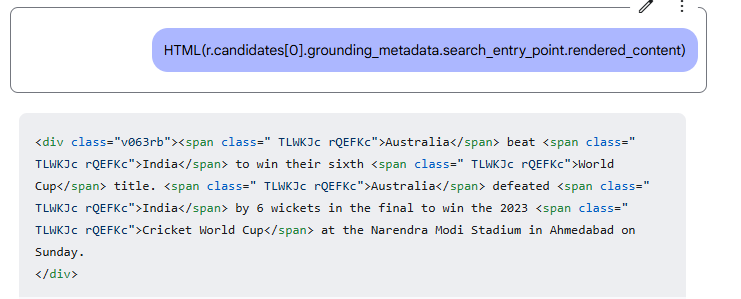

In [ ]:
# The dynamic retrieval score is a probability, so the threshold
# must also be bound by [0, 1].
search_config = {
    "dynamic_retrieval_config": {"mode": "MODE_DYNAMIC", "dynamic_threshold": 0.5}
}

maybe_search_model = genai.GenerativeModel(
    "gemini-1.5-flash-002", tools={"google_search_retrieval": search_config}
)

chat = maybe_search_model.start_chat()

r = chat.send_message("Hello friendly chatbot!")
rc = r.candidates[0]
score = rc.grounding_metadata.retrieval_metadata.google_search_dynamic_retrieval_score
print(f"First turn: {score=}")

r = chat.send_message("Who took home the 2023 cricket world cup?")
rc = r.candidates[0]
score = rc.grounding_metadata.retrieval_metadata.google_search_dynamic_retrieval_score
print(f"Second turn: {score=}")
print()

display(Markdown(r.text))

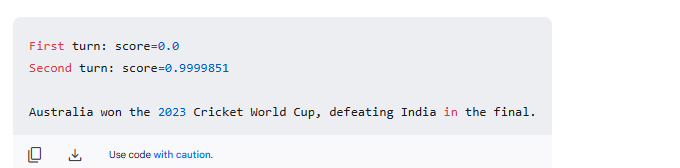

In [ ]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

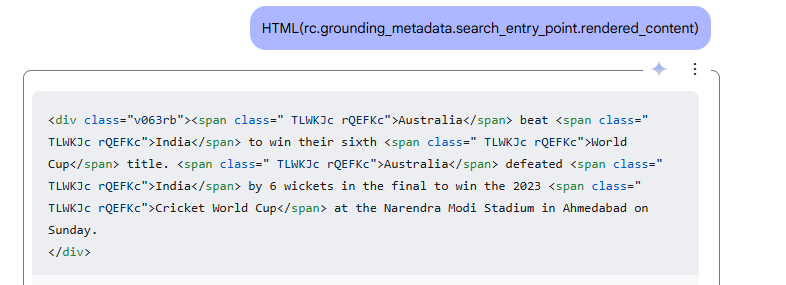

## Ejercicio 2 Ajuste fino de un modelo personalizado

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
%pip install -U -q 'google-generativeai>=0.8.3'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 4.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import google.generativeai as genai

## Configurando clave

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

## Explorando modelos

In [4]:
for model in genai.list_models():
    if "createTunedModel" in model.supported_generation_methods:
        print(model.name)

models/gemini-1.0-pro-001
models/gemini-1.5-flash-001-tuning


## Descargando el dataset

In [5]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## Preparando el dataset

In [7]:
import email
import re

import pandas as pd


def preprocess_newsgroup_row(data):
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    # Truncate the text to fit within the input limits
    text = text[:40000]

    return text


def preprocess_newsgroup_data(newsgroup_dataset):
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df

In [8]:
# Apply preprocessing to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


In [9]:
def sample_data(df, num_samples, classes_to_keep):
    # Sample rows, selecting num_samples of each Label.
    df = (
        df.groupby("Label")[df.columns]
        .apply(lambda x: x.sample(num_samples))
        .reset_index(drop=True)
    )

    df = df[df["Class Name"].str.contains(classes_to_keep)]
    df["Class Name"] = df["Class Name"].astype("category")

    return df


TRAIN_NUM_SAMPLES = 50
TEST_NUM_SAMPLES = 10
# Keep rec.* and sci.*
CLASSES_TO_KEEP = "^rec|^sci"

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

## Evaluando el modelo

In [10]:
sample_idx = 0
sample_row = preprocess_newsgroup_row(newsgroups_test.data[sample_idx])
sample_label = newsgroups_test.target_names[newsgroups_test.target[sample_idx]]

print(sample_row)
print('---')
print('Label:', sample_label)

Need info on 88-89 Bonneville


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler

---
Label: rec.autos


In [11]:
baseline_model = genai.GenerativeModel("gemini-1.5-flash-001")
response = baseline_model.generate_content(sample_row)
print(response.text)

You're right to be a little confused about the 88-89 Bonneville models! Pontiac offered a dizzying array of trim levels during those years. Here's a breakdown of the key differences and how they might impact value:

**1. Base Bonneville:**

* **Features:** The standard Bonneville came with a 3.8L V6 engine, cloth upholstery, basic power accessories, and a decent amount of standard equipment for the time.
* **Value:**  This is the most common trim level, and therefore often the least expensive. Expect to pay around $1,000 to $3,000 for a decent example in good condition.

**2. LE (Luxury Edition):**

* **Features:** Added features like a more luxurious interior, upgraded upholstery, possibly a cassette player, and a more powerful 3.8L V6 with slightly more horsepower.
* **Value:**  Slightly more expensive than the base model.  You'll probably see them priced in the $1,500 to $4,000 range.

**3. SE (Special Edition):**

* **Features:**  The SE was the sportier option.  It included featur

In [12]:
# Ask the model directly in a zero-shot prompt.

prompt = "From what newsgroup does the following message originate?"
baseline_response = baseline_model.generate_content([prompt, sample_row])
print(baseline_response.text)

This message likely originates from a **Buick-specific newsgroup or forum**. 

Here's why:

* **Subject:** The message focuses on a specific car model: the 1988-1989 Buick Bonneville. 
* **Terminology:** The message uses model trims specific to the Bonneville (LE, SE, LSE, SSE, SSEi), indicating knowledge of the car's variations.
* **Question:** The message asks about the "book value" of the car, which is a common topic discussed in car-related forums and newsgroups. 

**Possible newsgroup names:**

* **alt.autos.buick**
* **rec.autos.buick**
* **comp.cars.buick** (less likely, but possible)

While the exact newsgroup is hard to determine without more context, it's clear the message originates from a community interested in Buick vehicles, particularly the Bonneville model. 



In [13]:
from google.api_core import retry

# You can use a system instruction to do more direct prompting, and get a
# more succinct answer.

system_instruct = """
You are a classification service. You will be passed input that represents
a newsgroup post and you must respond with the newsgroup from which the post
originates.
"""

instructed_model = genai.GenerativeModel("gemini-1.5-flash-001",
                                         system_instruction=system_instruct)

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

# If you want to evaluate your own technique, replace this function with your
# model, prompt and other code and return the predicted answer.
def predict_label(post: str) -> str:
    response = instructed_model.generate_content(post, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        # Clean up the response.
        return response.text.strip()


prediction = predict_label(sample_row)

print(prediction)
print()
print("Correct!" if prediction == sample_label else "Incorrect.")

rec.autos.misc

Incorrect.


In [14]:
from tqdm.rich import tqdm

tqdm.pandas()


# Further sample the test data to be mindful of the free-tier quota.
df_baseline_eval = sample_data(df_test, 2, '.*')

# Make predictions using the sampled data.
df_baseline_eval['Prediction'] = df_baseline_eval['Text'].progress_apply(predict_label)

# And calculate the accuracy.
accuracy = (df_baseline_eval["Class Name"] == df_baseline_eval["Prediction"]).sum() / len(df_baseline_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

/usr/local/lib/python3.10/dist-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy: 12.50%


In [15]:
df_baseline_eval

,Text,Label,Class Name,Prediction
0,Re: service indicator of a BMW\n\n\nIn article...,7,rec.autos,rec.autos.bmw
1,"Re: Honda clutch chatter\n\nIn article <>, (J...",7,rec.autos,rec.autos.honda
2,Re: Zipper repairs (Was: ...Tankbag...)\n\nIn ...,8,rec.motorcycles,rec.motorcycles
3,Re: FJ1100/1200 Owners: Tankbag Suggestions Wa...,8,rec.motorcycles,rec.motorcycles.honda
4,Re: White and black - racism: was about the ph...,9,rec.sport.baseball,rec.sports.baseball
5,Re: Game Length (was Re: Braves Update!!\n <> ...,9,rec.sport.baseball,rec.sports.baseball
6,Re: Don Cherry-New Pens Annoucer?\n\n\nIn arti...,10,rec.sport.hockey,rec.sports.hockey
7,Re: Oiler's rumour - Team moving? Press confer...,10,rec.sport.hockey,rec.sport.hockey
8,"Re: I have seen the lobby, and it is us\n\n1) ...",11,sci.crypt,alt.politics.clinton
9,Re: Implementing a Diffie-Hellman key exchange...,11,sci.crypt,(error)


In [16]:
from collections.abc import Iterable
import random


# Append a random number to the model ID so you can re-run with a higher chance
# of creating a unique model ID.
model_id = f"newsgroup-classifier-{random.randint(10000, 99999)}"

# Upload the training data and queue the tuning job.
tuning_op = genai.create_tuned_model(
    "models/gemini-1.5-flash-001-tuning",
    training_data=df_train,
    input_key="Text",  # the column to use as input
    output_key="Class Name",  # the column to use as output
    id=model_id,
    display_name="Newsgroup classification model",
    batch_size=16,
    epoch_count=2,
)

print(model_id)

newsgroup-classifier-44860


State.CREATING
State.CREATING
State.CREATING
State.CREATING
Done! The model is ACTIVE


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='step', ylabel='mean_loss'>

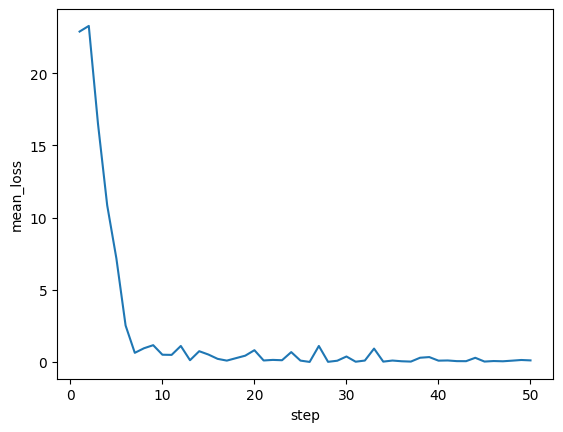

In [17]:
import time
import seaborn as sns


while (tuned_model := genai.get_tuned_model(f"tunedModels/{model_id}")).state.name != 'ACTIVE':

    print(tuned_model.state)
    time.sleep(60)

print(f"Done! The model is {tuned_model.state.name}")

# Plot the loss curve.
snapshots = pd.DataFrame(tuned_model.tuning_task.snapshots)
sns.lineplot(data=snapshots, x="step", y="mean_loss")

## Usando el nuevo modelo

In [18]:
your_model = genai.GenerativeModel(f"tunedModels/{model_id}")

new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

response = your_model.generate_content(new_text)
print(response.text)

sci.space


## Evaluación

In [19]:
def classify_text(text: str) -> str:
    """Classify the provided text into a known newsgroup."""
    response = your_model.generate_content(text, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        return rc.content.parts[0].text


# The sampling here is just to minimise your quota usage. If you can, you should
# evaluate the whole test set with `df_model_eval = df_test.copy()`.
df_model_eval = sample_data(df_test, 4, '.*')


df_model_eval["Prediction"] = df_model_eval["Text"].progress_apply(classify_text)

accuracy = (df_model_eval["Class Name"] == df_model_eval["Prediction"]).sum() / len(df_model_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

/usr/local/lib/python3.10/dist-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy: 78.12%


## Comparando tokens

In [20]:
# Calculate the *input* cost of the baseline model with system instructions.
sysint_tokens = instructed_model.count_tokens(sample_row).total_tokens
print(f'System instructed baseline model: {sysint_tokens} (input)')

# Calculate the input cost of the tuned model.
tuned_tokens = your_model.count_tokens(sample_row).total_tokens
print(f'Tuned model: {tuned_tokens} (input)')

savings = (sysint_tokens - tuned_tokens) / tuned_tokens
print(f'Token savings: {savings:.2%}')  # Note that this is only n=1.

System instructed baseline model: 171 (input)
Tuned model: 135 (input)
Token savings: 26.67%


In [21]:
baseline_token_output = baseline_response.usage_metadata.candidates_token_count
print('Baseline (verbose) output tokens:', baseline_token_output)

tuned_model_output = your_model.generate_content(sample_row)
tuned_tokens_output = tuned_model_output.usage_metadata.candidates_token_count
print('Tuned output tokens:', tuned_tokens_output)

Baseline (verbose) output tokens: 200
Tuned output tokens: 4
